## Manifold Scultping

In this folder is provided an implementation in Python of the Manifold Scultping algorithm, as described in the paper "Iterative Non-linear Dimensionality Reduction by Manifold Sculpting" by Michael Gashler, Dan Ventura, and Tony Martinez.

In this notebook, the steps are shown by one by one in order to illustrate the functioning of the algorithm.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from pca import *
from manifold_scultpting import *
from utils import *

In [2]:
import ipywidgets as widgets # this is needed to make the 3d plot interactive

### 1st step: find k nearest neighbors of each point
### 2nd point: compute relationships between neighbors


These two steps are merged in a unique one which is implemented by the function `get_local_relationships(data, k)`, which takes as input the data matrix `X` and the number of neighbors `k` and returns the matrices of relationships between neighbors and the average distance between each point and its neighbors.

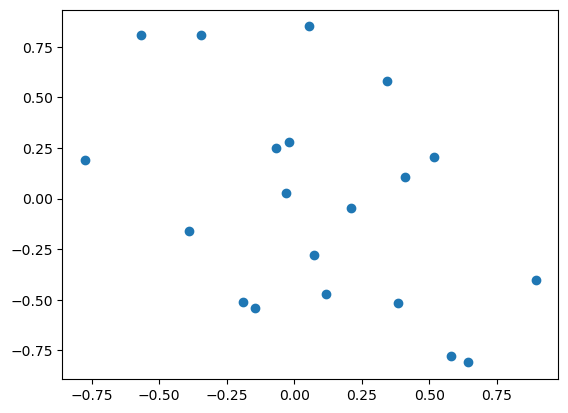

In [3]:
# generate random datapoints
# generate random points in 2d and plot them
data = np.random.uniform(-1, 1, (20, 2))
plt.scatter(data[:,0], data[:,1])
plt.show()

In [4]:
# call function to get the desired relationships
neighbors, dist, colinear, theta, avg_dist = get_local_relationships(data, k=5)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


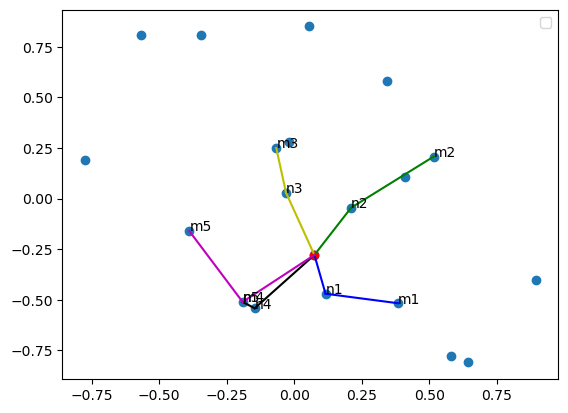

In [5]:
# choose one point and plot relationships
point = 4
plt.scatter(data[:,0], data[:,1])
plt.scatter(data[point,0], data[point,1], c='r')

color = ['b', 'g', 'y', 'k', 'm']
for i in range(5):
    j = int(neighbors[point, i])
    plt.plot([data[point,0], data[j,0]], [data[point,1], data[j,1]], c=color[i])
    plt.annotate('n%d' %(i+1), (data[j,0], data[j,1]))


# plot the most colinear neighbor of each neighbor of the chosen point
for i,idx in enumerate(colinear[point,:]):
    j = int(neighbors[point, i])
    plt.plot([data[j,0], data[int(idx),0]], [data[j,1], data[int(idx), 1]], c=color[i])
    plt.annotate('m%d' %(i+1), (data[int(idx),0], data[int(idx),1]))

plt.legend()
plt.show()


### Step 3: optionally preprocess the data

The following steps are illustrated on the data set `swiss_roll` which is a 3D data set with a non-linear structure. The data set is loaded and plotted below.

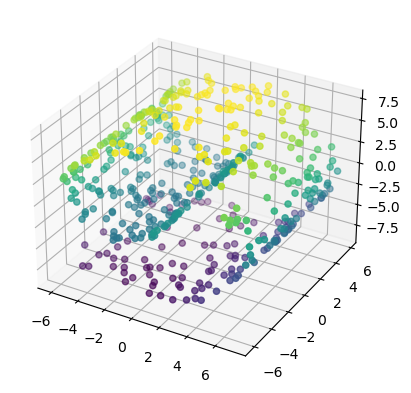

In [30]:
# generate swiss roll dataset
#data = generate_swiss_roll(500)

# center the data
X = data - np.mean(data, axis=0)
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X[:,0], X[:,1], X[:,2], c=X[:,2], cmap='viridis')

plt.show()

PCA is used to find the first $|D_{pres}|$ principal components (n. of dimensions to be preserved) and optionally rotate the dimensional axes to align with these principal components. No projection is performed, then the implementation provided for PCA removes the last step of the standard PCA algorithm.

In [43]:
cm = np.cov(X.T)
# extract diagonal from covariance matrix
d = np.diag(cm)
# sort in descending order
d = np.argsort(d)[::-1]
d

array([2, 0, 1], dtype=int64)

In [41]:
np.linalg.eig(cm)

(array([11.62572222, 17.12329926, 23.12923154]),
 array([[-0.15817406,  0.98694344, -0.03039097],
        [ 0.97391917,  0.16100949,  0.15986679],
        [-0.16267271,  0.00431156,  0.98667066]]))

In [34]:
pca.components_

array([[ 0.03039097, -0.15986679, -0.98667066],
       [ 0.98694344,  0.16100949,  0.00431156]])

In [31]:
def pca_alg(X, n_components):
        
    # calculate the covariance matrix
    # np.cov takes a matrix whose rows are the variables and columns are the observations
    # so we need to transpose the matrix
    cov_matrix = np.cov(X.astype(float).T)

    # calculate the eigenvalues and eigenvectors
    eigenvalues, eigenvectors = np.linalg.eig(cov_matrix)

    # sort the eigenvalues and eigenvectors in descending order
    idx = eigenvalues.argsort()[::-1]
    print(eigenvalues)
    eigenvalues = eigenvalues[idx]
    print(eigenvalues)
    eigenvectors = eigenvectors[:,idx]

    # keep the first n_components eigenvectors,
    # which will made our matrix U
    U = eigenvectors[:,:n_components]

    return idx, U

[11.62572222 17.12329926 23.12923154]
[23.12923154 17.12329926 11.62572222]


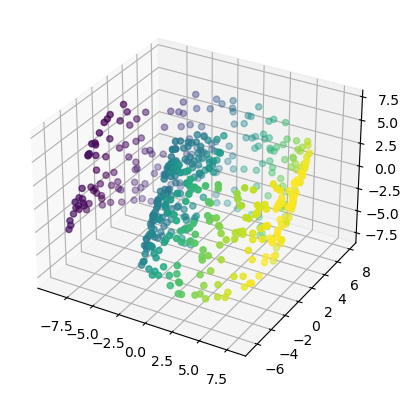

In [32]:
# apply pca to the data
idx, U = pca_alg(X, 3) # keep all dimensions to see just the rotation
y = np.dot(X, U)

# plot the data in the new space
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(y[:,0], y[:,1], y[:,2], c=X[:,2], cmap='viridis')

plt.show()

In [21]:
idx

array([2, 1, 0], dtype=int64)

In [24]:
a = [2,0,4]
np.argsort(a)[::-1]

array([2, 0, 1], dtype=int64)

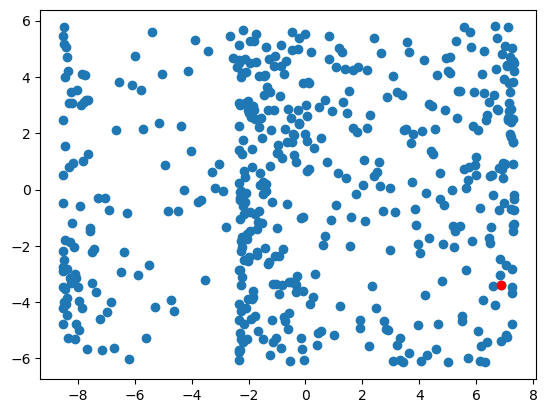

In [25]:
#plot 2d X
# plot 2d data
p = 300
plt.scatter(X[:,idx[0]], X[:,idx[1]])
plt.scatter(X[p,idx[0]], X[p,idx[1]], c='r')
plt.show()

Which dimensions PCA is preserving? 

Those are the ones which are going to be selected by **Manifold algorithm** to be the ones which make $D_{pres}$, while the others are in $D_{scal}$ and information is going to be scaled out of them. 

This is the result of the PCA preprocessing step, if we apply also the projection, we obtain the following result.

Manifold Sculpting uses PCA only to find the dimensions to be preserved and to align axes with principal components in order to make the algorithm faster, but the projection is not performed, it is progressively achieved thorugh an iterative procedure.

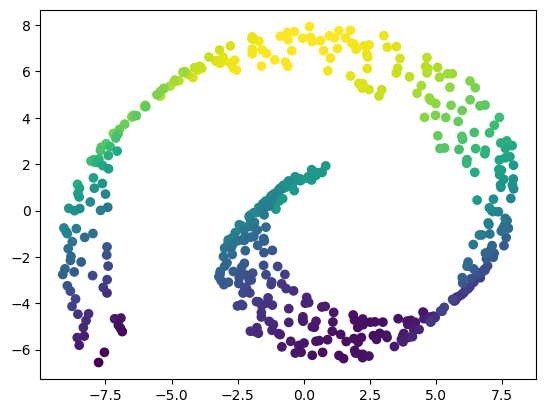

In [18]:
fig = plt.figure()

ax = fig.add_subplot(111)
ax.scatter(y[:,0], y[:,1], c=X[:,0], cmap='viridis')

Going back for a moment to what concerns step 1 and 2.

An important thing to decide, related to dataset we are dealing with, is hyperparameter $k$, which is the number of neighbors to be considered.
This is very important, a suitable value can be found by visualizing which points are connected and avoid to have to many points connected across different parts of the manifold.

In [10]:
ds = copy.deepcopy(X)
nn=12

# call function to get the desired relationships
neighbors, dist, colinear, theta, avg_dist = get_local_relationships(ds, k=nn)
neighbors.shape

(500, 12)

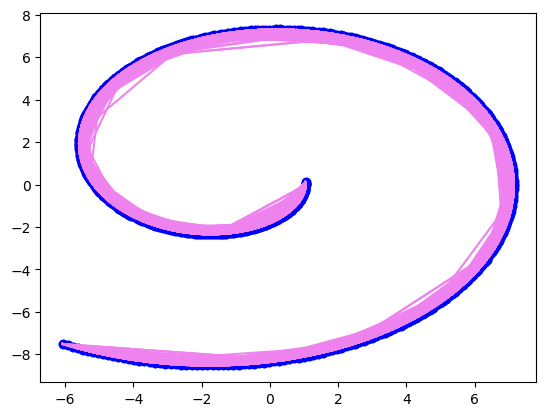

In [11]:
%matplotlib inline

# choose one point and plot relationships
plt.scatter(ds[:,0], ds[:,2])
for point in range(data.shape[0]):
    plt.scatter(ds[point,0], ds[point,2], c='b')

# plot the neighbors of each point
for point in range(data.shape[0]):
    for i in range(nn):
        j = int(neighbors[point, i])
        plt.plot([ds[point,0], ds[j,0]], [ds[point,2], ds[j,2]], c='violet')


# plot the most colinear neighbor of each neighbor for each point
for point in range(data.shape[0]):
    for i,idx in enumerate(colinear[point,:]):
        plt.plot([ds[point,0], ds[int(idx),0]], [ds[point,2], ds[int(idx), 2]], c='violet')


plt.show()

### Step 4: Transform the data
- Scale the values along the dimensions to be discarded.
- Restore the original relationships found at step 2.


### Step 5: project the data

In [85]:
from manifold_sculpt_class import *

ms = ManifoldSculpting(n_components=2, k=10, n_iter=100, sigma = 0.9, th = 10**(-5), align=True, verbose=True)
ms.fit(X)

Dimensions which are going to be preserved:  [2 1]
Dimensions which are going to be discarded:  [0]
Iteration: 0, change: 559.6062196834432
Iteration: 10, change: 653.2630273332368
Iteration: 20, change: 801.8833424242316
Iteration: 30, change: 698.3298990200249
Iteration: 40, change: 891.630469259541
Iteration: 50, change: 927.0757311773243
Iteration: 60, change: 923.0954579407893
Iteration: 70, change: 869.3426308494904
Iteration: 80, change: 810.3462082436145
Iteration: 90, change: 991.2153628282599
Final reconstruction error: 230.08705193485116


In [92]:
# get embedding
y = ms.transformed_data
y.shape

(500, 3)

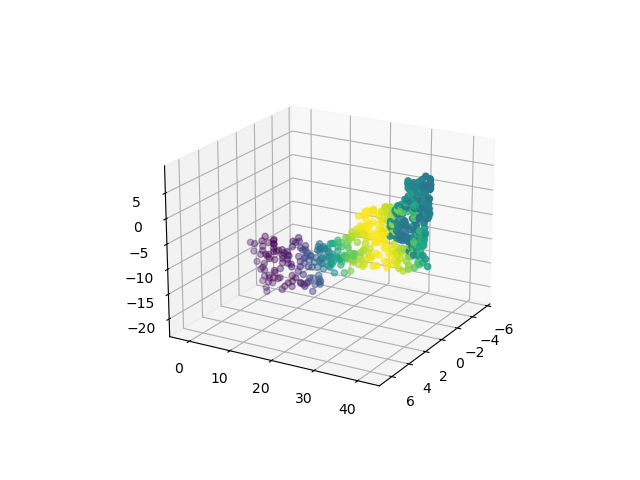

In [93]:
%matplotlib widget  

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(y[:,0], y[:,1], y[:,2], c=X[:,2], cmap='viridis')


# change the angle of the axes
ax.view_init(20, 30)

if idx[-1] == 0:
    ax.set_xlim(np.min(X[:,0]),np.max(X[:,0]))
elif idx[-1] == 1:
    ax.set_ylim(np.min(X[:,1]),np.max(X[:,1]))
else:
    ax.set_zlim(np.min(X[:,2]),np.max(X[:,2]))

plt.show()

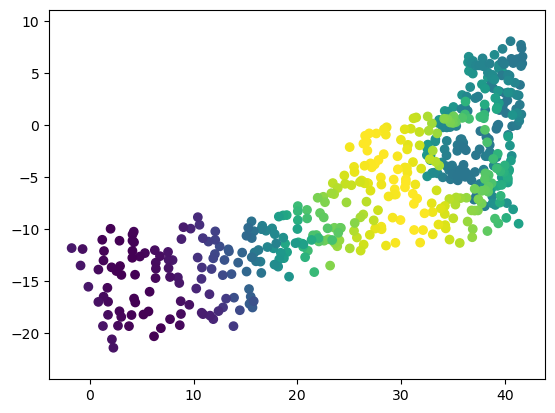

In [90]:
%matplotlib inline

y = ms.embedding
plt.scatter(y[:,1], y[:,0], c=X[:,2], cmap='viridis')
# make axis equal
plt.axis('equal')
plt.show()

### Comparisons

Let's check which is the behavior of other **manifold learning** techniques we have seen, on the same dataset.

1. **Isomap**

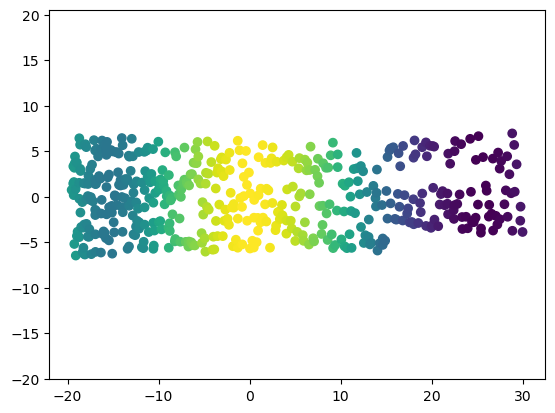

In [55]:
from sklearn.manifold import Isomap # for Isomap dimensionality reduction

isomap = Isomap(n_components=2, n_neighbors=12, path_method='FW', neighbors_algorithm='brute')
isomap.fit(X)

fig = plt.figure()
ax = fig.add_subplot(111)
ax.scatter(isomap.embedding_[:, 0], isomap.embedding_[:, 1], c=X[:,2], cmap='viridis')
plt.axis('equal')

plt.show()

2. t-SNE

In [59]:
from sklearn.manifold import TSNE


tsne = TSNE(n_components=2, perplexity=30, n_iter=1000, learning_rate='auto')
embed = tsne.fit_transform(X)

embed.shape

c:\Users\Erika\AppData\Local\R-MINI~1\envs\deep-learn\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(


(500, 2)

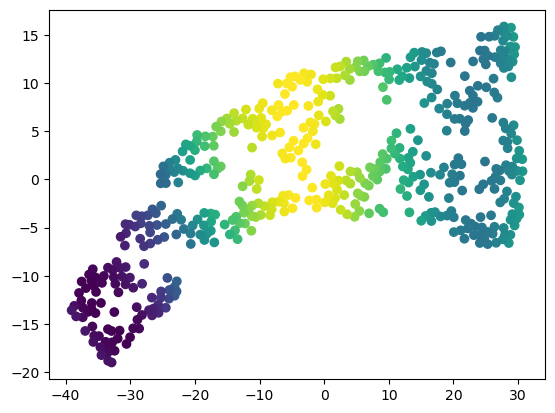

In [60]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.scatter(embed[:, 0], embed[:, 1], c=X[:,2], cmap='viridis')

plt.show()

3. **LLE**

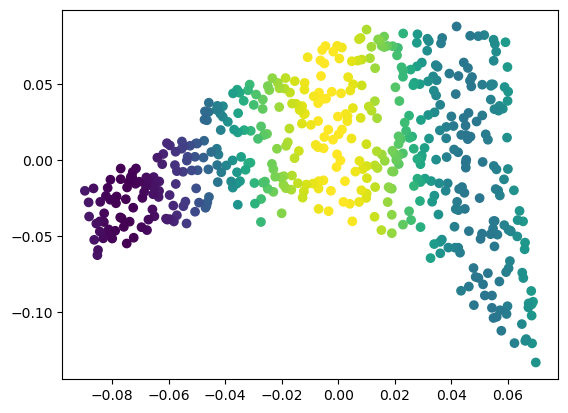

In [61]:
from sklearn import manifold

embed, _ = manifold.locally_linear_embedding(X, n_neighbors=12, n_components=2)


fig = plt.figure()
ax = fig.add_subplot(111)
ax.scatter(embed[:, 0], embed[:, 1], c=X[:,2], cmap='viridis')

plt.show()